# South Africa Crop Type Classification on Euro Data Cube (EDC)

This notebook shows the steps towards preparing data for training a supervised machine learning model on EDC. We will train the model based on the optical bands with 10 m resolution of Sentinel-2 imagery, i.e., the B2, B3, B4, and B8.

We will use the Long Short-Term Memory model (LSTM), a variation of a recurrent neural network (RNN), which learns the temporal context of a particular yearly time series of a crop.

As for the ground truth, we will use the [South Africa Crop Type Competition](https://collections.eurodatacube.com/south-africa-crops-competition/) collection, which is part of the EDC public collection and contains the field identification label representing the area of crop fields and the corresponding crop type collected via aerial and vehicle surveys.

In this example notebook, the expected outcome is a muticlass classifier that identifies different crop types planted in the fields in South Africa. 

We will prepare the training data in the following steps:
1. Search for available ground truth labels
2. Download features and labels
3. Reshape data for model training
4. Normalize and undersample data
5. Train model
6. Run model on validation data
7. Evaluate results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

print(sys.version)

# NOTE: all necessary packages are preinstalled in the EuroDataCube curated 'edcg-2023.10-01' conda kernel!

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [3]:
import datetime
import os
import pickle
from collections import defaultdict

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from eolearn.core import (
    EOExecutor,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    OverwritePermission,
    SaveTask,
    linearly_connect_tasks,
)
from eolearn.features.extra.interpolation import LinearInterpolationTask
from eolearn.io import SentinelHubEvalscriptTask, SentinelHubInputTask
from matplotlib.colors import BoundaryNorm, ListedColormap
from sentinelhub import (
    CRS,
    Band,
    BBox,
    DataCollection,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    SHConfig,
    Unit,
    UtmZoneSplitter,
    bbox_to_dimensions,
)
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

rng = np.random.default_rng(42)

# 1. Search for available ground truth's labels

To start preparing a training dataset, we need to find the areas which contain ground truth available in the [South Africa Crop Type Competition](https://collections.eurodatacube.com/south-africa-crops-competition/) data collection on EDC. We will use the geographical coverage and the temporal availability provided on the linked webpage above to make a Catalog API request.

In [4]:
# load the SH config
config = SHConfig()

# split the AOI into 2560m x 2560m tiles
extent = BBox((17.85, -33.089240, 18.193359, -32.7), crs=CRS.WGS84)
bbox_list = UtmZoneSplitter([extent.geometry], crs=extent.crs, bbox_size=[2560, 2560]).bbox_list

/home/conda/users/78c2e9a35d8f916b51e069b3359b976953e33c4ac102d2c530b5373dd8486c9d-20240215-082503-014013-382-edcg-2023.10-01/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/conda/users/78c2e9a35d8f916b51e069b3359b976953e33c4ac102d2c530b5373dd8486c9d-20240215-082503-014013-382-edcg-2023.10-01/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


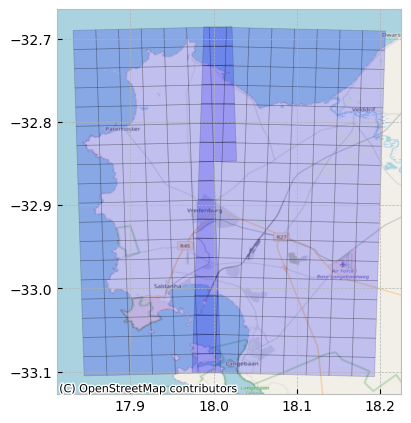

In [5]:
plt.style.use(["default", "bmh"])
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_alpha(1)

# construct grid for plotting
grid = defaultdict(list)
for idx, bbox in enumerate(bbox_list):
    grid[bbox.crs.epsg].append({"geometry": bbox.geometry, "bbox_id": idx})

gdf_list = [
    gpd.GeoDataFrame(subset, geometry="geometry", crs=crs).to_crs(CRS.WGS84.epsg) for crs, subset in grid.items()
]
gdf = pd.concat(gdf_list).sort_values("bbox_id").reset_index(drop=True)

# plot grid and basemap
gdf.plot(edgecolor="k", alpha=0.2, ax=ax)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)

In [6]:
def get_coverage_request(
    bbox: BBox,
    time_interval: tuple[str, str],
    evalscript: str,
    collection: DataCollection = DataCollection.SENTINEL2_L2A,
):
    """Construct request for SentinelHubStatistical data to get coverage of labels in the tile"""
    patch_size = bbox_to_dimensions(bbox, resolution=60)

    return SentinelHubStatistical(
        aggregation=SentinelHubStatistical.aggregation(
            evalscript=evalscript,
            time_interval=time_interval,
            aggregation_interval="P1D",
            size=patch_size,
        ),
        input_data=[SentinelHubStatistical.input_data(collection)],
        bbox=bbox,
    )


# prepare evalscript for downloading crop labels
labels_evalscript = """
//VERSION=3

function setup() {
    return {
        input: [
            {"bands": ["crop", "dataMask"]}
        ],
        output: [
            {
                id: "LABELS",
                bands: 1,
                sampleType: "UINT8"
            },
            {
                id: "dataMask",
                bands: 1,
                sampleType: "UINT8"
            }
        ]
    };
}

function evaluatePixel(sample) {
    return {LABELS: [sample.crop], dataMask: [sample.dataMask]};
}
"""

# define collection which points to crop labels
collection_id = "bd457670-af1b-45cd-bef2-6a7c93bf5e6e"
south_africa_crop = DataCollection.define_byoc(
    collection_id, bands=[Band(name="crop", units=(Unit.DN,), output_types=(np.uint8,))], metabands=[], is_timeless=True
)

# specify labels definition time (from webpage) and run the requests
labels_time_interval = ("2017-08-01", "2017-08-02")
kwargs = dict(time_interval=labels_time_interval, evalscript=labels_evalscript, collection=south_africa_crop)
requests = [get_coverage_request(bbox, **kwargs).download_list[0] for bbox in bbox_list]
client = SentinelHubStatisticalDownloadClient()

# download or load data from disk
if not os.path.exists("stats.pkl"):
    stats = client.download(requests)
    pickle.dump(stats, open("stats.pkl", "wb"))
else:
    stats = pickle.load(open("stats.pkl", "rb"))

In [7]:
def extract_coverage(stats: list[dict]):
    """Extract labels coverage from the statistical data"""
    data = stats["data"][0]["outputs"]["LABELS"]["bands"]["B0"]["stats"]
    return 1 - data["noDataCount"] / data["sampleCount"]


# extract coverage from the stats
coverages = np.array([extract_coverage(s) if s["data"] else 0 for s in stats])

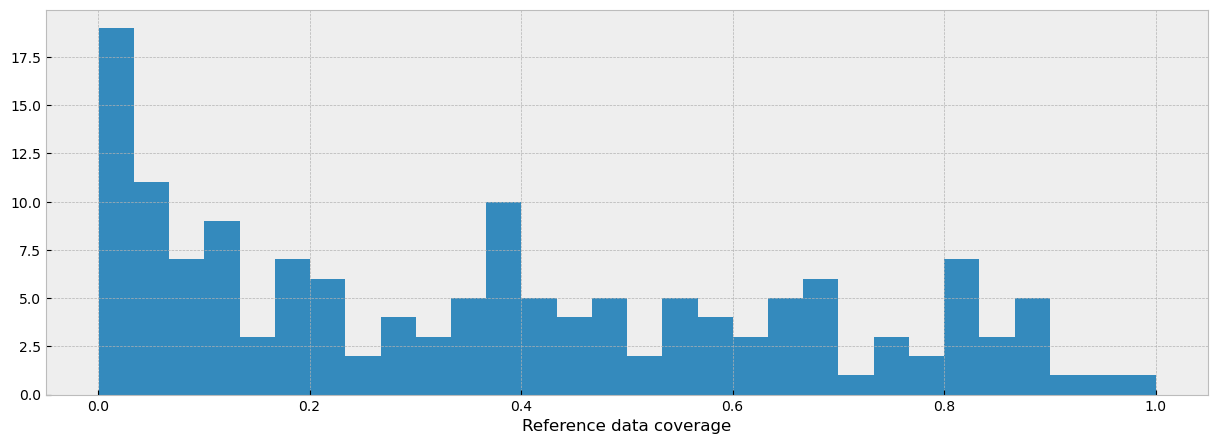

In [8]:
plt.style.use(["default", "bmh"])
fig, ax = plt.subplots(figsize=(15, 5))
fig.patch.set_alpha(1)

# plot labels coverage over tiles, ignore tiles with no data
ax.hist(coverages[coverages > 0], bins=30)
ax.set_xlabel("Reference data coverage");

In [9]:
# let's keep only the tiles with coverage above 40%
coverage_filter = np.array(coverages) > 0.40
print(f"{np.count_nonzero(coverage_filter)} eligible patches")

filtered = np.array(bbox_list)[coverage_filter]

63 eligible patches


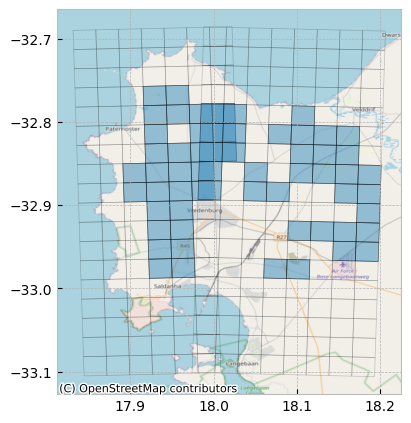

In [10]:
plt.style.use(["default", "bmh"])
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_alpha(1)

# set new column
gdf["eligible"] = coverage_filter

# plot grid and basemap
gdf.plot(color="none", edgecolor="k", alpha=0.2, ax=ax)
gdf[gdf["eligible"]].plot(color="C0", edgecolor="k", alpha=0.5, ax=ax)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)

# 2. Download features and labels

Now we know where the groud truth is available, we use eo-learn to download the data and the labels. This is what the eo-learn workflow does:
1. Download bands data (B, G, R, NIR)
2. Download labels data
3. Construct valid mask from data availability mask and cloud mask
4. Perform temporal interpolation and resample to uniform timestamps across whole AOI

For the purpose of this notebook, we will download only 2 EOPatches, but to properly train the model, set the `tutorial_mode` to `False` to properly train the model

In [11]:
tutorial_mode = True
if tutorial_mode:  # select first two eligible EOPatches
    subset = [18, 20]
    selected = filtered[subset]
    gdf["selected"] = False
    gdf.loc[gdf.loc[gdf.eligible].index[subset], "selected"] = True
else:  # select all eligible EOPatches
    selected = filtered
    gdf["selected"] = coverage_filter

In [13]:
# prepare task for joining valid data mask and cloud masks from SH
class SentinelHubValidDataTask(EOTask):
    """
    Combine the downloaded cloud mask with `IS_DATA` to define a valid data mask
    The SentinelHub's cloud mask is expected in eopatch.mask['CLM']
    """

    def __init__(self, output_feature):
        self.output_feature = output_feature

    def execute(self, eopatch):
        eopatch[self.output_feature] = eopatch.mask["IS_DATA"].astype(bool) & (~eopatch.mask["CLM"].astype(bool))
        return eopatch


# BAND DATA
# Add a request for S2 bands.
# Here we also do a simple filter of cloudy scenes (on tile level).
# The s2cloudless masks are requested via additional data.
band_names = ["B02", "B03", "B04", "B08"]
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L2A,
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM")],
    max_threads=5,
)

# LABELS DATA
# Add a request for crop labels.
add_labels = SentinelHubEvalscriptTask(
    features=(FeatureType.MASK_TIMELESS, "LABELS"),
    evalscript=labels_evalscript,
    data_collection=south_africa_crop,
    resolution=10,
    max_threads=5,
)

# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = SentinelHubValidDataTask((FeatureType.MASK, "IS_VALID"))

# LINEAR TEMPORAL INTERPOLATION
# linear interpolation of full time-series and date resampling
# needed to evaluate time series at specific dates for all data
time_interval = ("2017-01-01", "2017-12-31")
resampled_range = (time_interval[0], time_interval[1], 15)  # define target timestamps (every 15 days)
linear_interp = LinearInterpolationTask(
    (FeatureType.DATA, "BANDS"),  # name of field to interpolate
    mask_feature=(FeatureType.MASK, "IS_VALID"),  # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, "LABELS")],  # features to keep
    resample_range=resampled_range,
)

# SAVING TO OUTPUT
save = SaveTask("./eopatches", overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

In [14]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
    add_data,
    add_labels,
    add_sh_validmask,
    linear_interp,
    save,
)
workflow = EOWorkflow(workflow_nodes)

# Define additional parameters of the workflow
input_bands = workflow_nodes[0]
save_node = workflow_nodes[-1]
execution_args = []
for idx, bbox in enumerate(selected):
    execution_args.append(
        {
            input_bands: {"bbox": bbox, "time_interval": time_interval},
            save_node: {"eopatch_folder": f"eopatch_{idx}"},
        }
    )

# Execute the workflow
if not os.path.exists("eopatches"):
    executor = EOExecutor(workflow, execution_args, save_logs=True)
    executor.run(workers=2)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# collect the data and labels over all eopatches
data_list = []
labels_list = []
for eop_idx in tqdm(range(len(selected))):
    eop = EOPatch.load(f"./eopatches/eopatch_{eop_idx}")
    data_list.append(eop.data["BANDS"])
    labels_list.append(eop.mask_timeless["LABELS"])

In [ ]:
# plot selected scenes in true color
ncols = 2
nrows = 1
time_idx = 12

plt.style.use(["default", "bmh"])
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 2, nrows * 2))
fig.patch.set_alpha(1)

for ax, image in zip(axs.flatten(), data_list):
    ax.imshow(np.clip(image[time_idx][..., [2, 1, 0]] * 3.5, 0, 1))
    ax.axis("off")

plt.tight_layout()

In [ ]:
# plot also labels
ncols = 2
nrows = 1

label_codes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
label_colors = [
    "#ffffff",
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
]
label_text = [
    "No data",
    "Lucerne/Medics",
    "Planted pastures (perennial)",
    "Fallow",
    "Wine grapes",
    "Weeds",
    "Small grain grazing",
    "Wheat",
    "Canola",
    "Rooibos",
]

plt.style.use(["default", "bmh"])
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 2, nrows * 2))
fig.patch.set_alpha(1)

cmap = ListedColormap(label_colors)
norm = BoundaryNorm(label_codes, 10)

for ax, image in zip(axs.flatten(), labels_list):
    ax.imshow(image.squeeze(-1), cmap=cmap, norm=norm, interpolation="none")
    ax.axis("off")

plt.tight_layout()

# 3. Reshape data for model training

The data for the LSTM model needs to be in the form of `N x T x C`, where _N_ represents the number of pixels, _T_ represents the number of timestamps, and _C_ the number of channels.

We have 25 timestamps and 4 channels (B, G, R, NIR).

In [ ]:
# split tiles into train and validation patches
train_slice = slice(None, None, 2)  # evens
val_slice = slice(1, None, 2)  # odds

train_data, train_labels = data_list[train_slice], labels_list[train_slice]
validate_data, validate_labels = data_list[val_slice], labels_list[val_slice]

sel_gdf = gdf[gdf.selected].copy()
sel_gdf["train_split"] = False
sel_gdf.loc[train_slice, "train_split"] = True

plt.style.use(["default", "bmh"])
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_alpha(1)

# plot grid and basemap
gdf.plot(color="none", edgecolor="k", alpha=0.2, ax=ax)
sel_gdf[sel_gdf.train_split].plot(color="xkcd:green", edgecolor="k", alpha=0.2, ax=ax)
sel_gdf[~sel_gdf.train_split].plot(color="xkcd:brick", edgecolor="k", alpha=0.2, ax=ax)
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)

In [ ]:
# function for extracting and reshaping the data and labels
def get_model_input(data: np.ndarray, labels: np.ndarray) -> tuple:
    t, h, w, d = data.shape
    x = np.reshape(np.moveaxis(data, 0, -2), (h * w, t, d))  # N x T x C
    y = np.reshape(labels, (h * w))
    return x[y != 0], y[y != 0]

In [ ]:
# reshape for train data
x_train, y_train = [], []
for data, labels in zip(train_data, train_labels):
    model_input = get_model_input(data, labels)
    x_train.append(model_input[0])
    y_train.append(model_input[1])

x_train = np.concatenate(x_train, axis=0).astype(np.float32)
y_train = np.concatenate(y_train, axis=0).astype(np.uint8)
del train_data, train_labels

print(x_train.shape)
print(y_train.shape)

In [ ]:
# reshape for validation data
x_validate, y_validate = [], []
for data, labels in zip(validate_data, validate_labels):
    model_input = get_model_input(data, labels)
    x_validate.append(model_input[0])
    y_validate.append(model_input[1])

x_validate = np.concatenate(x_validate, axis=0).astype(np.float32)
y_validate = np.concatenate(y_validate, axis=0).astype(np.uint8)
del validate_data, validate_labels

print(x_validate.shape)
print(y_validate.shape)

In [ ]:
plt.style.use(["default", "bmh"])
fig, ax = plt.subplots(figsize=(15, 5), ncols=2, sharex=True)
fig.patch.set_alpha(1)

labels_dict = dict(zip(label_codes, label_text))

labels, counts = np.unique(y_train, return_counts=True)
ax[0].barh(range(len(labels)), counts)
ax[0].set_title("Train data labels distribution")
ax[0].set_yticks(range(len(labels)), [labels_dict[lbl] for lbl in labels])

labels, counts = np.unique(y_validate, return_counts=True)
ax[1].barh(range(len(labels)), counts)
ax[1].set_title("Validation data labels distribution")
ax[1].set_yticks(range(len(labels)), [labels_dict[lbl] for lbl in labels])

plt.tight_layout()

# 4. Normalize and undersample data

For the columns that contain numerical data, we should ensure the data range is normalized in case the data has different scales. This process may improve the models performance, and also preserve outliers.

Here we will use a simple method of undersampling just to minimize the amount of huge data we are handling, but the balance of the classes will remain the same.

In [ ]:
# set random seet
np.random.seed(42)

# define percentage of data to use
percentage = 0.3

# sample train data
sample_mask = np.random.choice(x_train.shape[0], int(percentage * x_train.shape[0]))
class_counts_before = np.unique(y_train, return_counts=True)
x_train = x_train[np.sort(sample_mask)]
y_train = y_train[np.sort(sample_mask)]
class_counts_after = np.unique(y_train, return_counts=True)

# sample validation data
sample_mask_val = np.random.choice(x_validate.shape[0], int(percentage * x_validate.shape[0]))
x_validate = x_validate[sample_mask_val]
y_validate = y_validate[sample_mask_val]

# normalize train data
n, t, c = x_train.shape
x_train = StandardScaler().fit_transform(x_train.reshape(n * t, c)).reshape(n, t, c)

# normalize validation data
n, t, c = x_validate.shape
val_scaler = StandardScaler().fit(x_validate.reshape(n * t, c))
x_validate = val_scaler.transform(x_validate.reshape(n * t, c)).reshape(n, t, c)

# check shapes
x_train.shape, x_validate.shape

In [ ]:
# fill nan values with -1
x_train = np.nan_to_num(x_train, nan=-1)
x_validate = np.nan_to_num(x_validate, nan=-1)

In [ ]:
# check labels distribution before and after undersampling
plt.style.use(["default", "bmh"])
fig, axs = plt.subplots(figsize=(12, 7), ncols=2)
fig.patch.set_alpha(1)

labels_dict = dict(zip(label_codes, label_text))
colors_dict = dict(zip(label_codes, label_colors))

axs[0].pie(
    class_counts_before[1],
    labels=[labels_dict[lbl] for lbl in class_counts_before[0]],
    autopct="%1.1f%%",
    colors=[colors_dict[lbl] for lbl in class_counts_before[0]],
    wedgeprops={"linewidth": 2, "edgecolor": "white", "alpha": 0.7},
)
axs[0].set_title("Class Distribution Before Undersampling")

axs[1].pie(
    class_counts_after[1],
    labels=[labels_dict[lbl] for lbl in class_counts_after[0]],
    autopct="%1.1f%%",
    colors=[colors_dict[lbl] for lbl in class_counts_after[0]],
    wedgeprops={"linewidth": 2, "edgecolor": "white", "alpha": 0.7},
)
axs[1].set_title("Class Distribution After Undersampling")

plt.tight_layout()

# 5. Train the model

Now it's time to construct and train the LSTM model. First we need a bunch of classes that the model will use, from the dataloaders to the model itself.

### Define the data loaders

In [ ]:
# class for the dataloader
class CustomImageDataset(Dataset):
    def __init__(self, x_data: np.ndarray, y_data: np.ndarray, encoder: LabelEncoder):
        self.x_data = x_data
        self.y_data = encoder.transform(y_data)

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]


# encode labels to 0 - num_labels
encoder = LabelEncoder().fit(list(set(y_train) | set(y_validate)))
for lbl in encoder.classes_:
    print(f"{lbl} -> {encoder.transform([lbl])[0]}")

In [ ]:
# define the batch size and the dataloaders for train/validation data
BATCH_SIZE = 1024 if tutorial_mode else 4096
train_dataloader = DataLoader(CustomImageDataset(x_train, y_train, encoder), batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(
    CustomImageDataset(x_validate, y_validate, encoder), batch_size=BATCH_SIZE, shuffle=True
)

## Define the model architecture

In [ ]:
class AverageMetric:
    """
    Simple class for averaging metrics.
    """

    def __init__(self):
        self.values = list()

    def add(self, new):
        self.values.append(new)

    def get(self):
        return np.array(self.values).mean()


# This code is taken from https://github.com/TUM-LMF/BreizhCrops
class LSTM(nn.Module):
    """
    Implementation of the LSTM model for classification of a input sequence into n classes.

    :param input_dim: number of input features entering LSTM cell (i.e. 13 if all S2 bands are used)
    :type input_dim: int
    :param n_classes: number of classes
    :type n_classes: int (class labels have to be between 0 and n_classes-1)
    :param hidden_dims: The number of features in the hidden state `h`
    :type hidden_dims: int
    :param num_rnn_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
                           would mean stacking two LSTMs together to form a `stacked LSTM`,
                           with the second LSTM taking in outputs of the first LSTM and
                           computing the final results.
    :type num_rnn_layers: int
    :param dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
                    LSTM layer except the last layer, with dropout probability equal to
                    :attr:`dropout`.
    :type dropout: float (between 0.0 and 1.0)
    :param bidirectional: If ``True``, becomes a bidirectional LSTM.
    :type bidirectional: bool
    :param use_batchnorm: If ``True``, use batch normalization.
    :type use_batchnorm: bool
    :param use_layernorm: If ``True``, applies Layer Normalization over a mini-batch of inputs.
    :type use_layernorm: bool
    """

    def __init__(
        self,
        input_dim,
        n_classes,
        hidden_dims,
        num_rnn_layers=1,
        dropout=0,
        bidirectional=False,
        use_batchnorm=False,
        use_layernorm=True,
    ):
        super().__init__()

        self.nclasses = n_classes
        self.use_batchnorm = use_batchnorm
        self.use_layernorm = use_layernorm

        self.d_model = num_rnn_layers * hidden_dims
        if use_layernorm:
            self.inlayernorm = nn.LayerNorm(input_dim)
            self.clayernorm = nn.LayerNorm((hidden_dims + hidden_dims * bidirectional) * num_rnn_layers)

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dims,
            num_layers=num_rnn_layers,
            bias=False,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional,
        )

        if bidirectional:
            hidden_dims = hidden_dims * 2

        self.linear_class = nn.Linear(hidden_dims * num_rnn_layers, n_classes, bias=True)

        if use_batchnorm:
            self.bn = nn.BatchNorm1d(hidden_dims)

    def _logits(self, x):
        x = x.transpose(1, 2)

        if self.use_layernorm:
            x = self.inlayernorm(x)

        outputs, last_state_list = self.lstm.forward(x)

        # TODO: check what is goinig on here
        if self.use_batchnorm:
            b, t, d = outputs.shape
            o_ = outputs.view(b, -1, d).permute(0, 2, 1)
            outputs = self.bn(o_).permute(0, 2, 1).view(b, t, d)

        h, c = last_state_list

        nlayers, batchsize, n_hidden = c.shape
        # TODO: shouldn't this be executed only uf layernorm is True
        h = self.clayernorm(c.transpose(0, 1).contiguous().view(batchsize, nlayers * n_hidden))
        logits = self.linear_class.forward(h)

        return logits

    def forward(self, x):
        logits = self._logits(x)
        logprobabilities = F.log_softmax(logits, dim=-1)
        return logprobabilities

    def save(self, path="model.pth", **kwargs):
        model_state = self.state_dict()
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(dict(model_state=model_state, **kwargs), path)

    def load(self, path):
        snapshot = torch.load(path, map_location="cpu")
        model_state = snapshot.pop("model_state", snapshot)
        self.load_state_dict(model_state)
        return snapshot

    def update_and_freeze_body(self, pretrained, freeze_layers=(0, -1)):
        self.inlayernorm = pretrained.inlayernorm
        self.clayernorm = pretrained.clayernorm
        self.lstm = pretrained.lstm

        for child in list(self.children())[freeze_layers[0] : freeze_layers[1]]:
            for param in child.parameters():
                param.requires_grad = False

    def unfreeze(self):
        for child in self.children():
            for param in child.parameters():
                param.requires_grad = True


def train(model, optimizer, train_loader, validation_loader, epochs):
    """
    Vanilla function to run the inference on all train samples given in training dataloader.
    At each epoch end the loss and accuracy of samples from the validation loader are printed.
    """
    model.train()

    if torch.cuda.is_available():
        model = model.cuda()

    for epoch in range(epochs):
        # train phase
        train_loss_log = AverageMetric()
        model.train()
        for data in train_loader:
            optimizer.zero_grad()

            inputs, targets = data

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()

            logprobabilities = model.forward(inputs.transpose(1, 2))

            loss = torch.nn.functional.nll_loss(logprobabilities, targets)
            train_loss_log.add(loss.cpu().detach().numpy())

            loss.backward()
            optimizer.step()

        # val phase
        val_loss_log = AverageMetric()
        model.eval()
        predictions_list = list()
        targets_list = list()
        for _, data in enumerate(validation_loader):
            inputs, targets = data

            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()

            logprobabilities = model.forward(inputs.transpose(1, 2))
            loss = torch.nn.functional.nll_loss(logprobabilities, targets)
            val_loss_log.add(loss.cpu().detach().numpy())

            targets_list.append(targets.cpu().detach().numpy())
            predictions_list.append((logprobabilities.cpu().detach().numpy()).argmax(1))

        val_acc = accuracy_score(np.concatenate(targets_list), np.concatenate(predictions_list))
        print(
            f"Epoch {epoch}: train loss {train_loss_log.get():.3f} | "
            f"val loss {val_loss_log.get():.3f} | "
            f"val acc = {val_acc:.3f}"
        )

    return model

In [ ]:
# set up the model
model = LSTM(
    input_dim=x_train.shape[-1],
    n_classes=len(encoder.classes_),
    hidden_dims=128,
    num_rnn_layers=3,
    dropout=0.1,
    bidirectional=True,
    use_batchnorm=False,
    use_layernorm=True,
)

# set up the optimizer
optimizer = Adam(model.parameters(), lr=5e-5)

In [ ]:
model_path = "./model.pth"
if not os.path.exists(model_path):
    n_epochs = 2 if tutorial_mode else 50
    # train the model for a few epochs and save when training is done
    model = train(model, optimizer, train_dataloader, validation_dataloader, epochs=n_epochs)
    model.save(model_path)
else:
    # or load the saved model from path
    model = LSTM(
        input_dim=x_train.shape[-1],
        n_classes=len(encoder.classes_),
        hidden_dims=128,
        num_rnn_layers=3,
        dropout=0.1,
        bidirectional=True,
        use_batchnorm=False,
        use_layernorm=True,
    )
    model.load(model_path)
    model.eval()

# 6. Run the model on validation data

Now that the model is trained, let's run it on the validation data and see how well it performs.

In [ ]:
# convert validation data to the proper format for inference
n_samples = 2000 if tutorial_mode else 10000
val_sample_mask = np.random.choice(range(len(x_validate)), n_samples)
val_tensor = torch.from_numpy(x_validate[val_sample_mask]).transpose(1, 2)
logprobas = model.forward(val_tensor).cpu().detach().numpy()

In [ ]:
# calculate the confidence and predictions
probas = np.exp(logprobas)
predictions = encoder.classes_[probas.argmax(axis=1)]

In [ ]:
# Calculate Accuracy, Precision and Recall, F1-Score
y_true = y_validate[val_sample_mask]
labels = sorted(set(y_true) | set(predictions))

accuracy = accuracy_score(y_true, predictions)
precision = precision_score(y_true, predictions, average=None, labels=labels)
recall = recall_score(y_true, predictions, average=None, labels=labels)
f1 = f1_score(y_true, predictions, average=None, labels=labels)

Plot F1-score per label

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

# calculate F1 score dataframe
df_f1 = pd.DataFrame({"Code": lbl, "Label": [labels_dict[lbl] for lbl in labels], "F1 score": f1})

# plot scores
ax.barh(df_f1["Label"], df_f1["F1 score"])

ax.set_title("Labels F1-Score")
ax.set_xlabel("F1-Score")

 Plot confusion matrix

In [ ]:
true_labels_counts_dict = dict(zip(*np.unique(y_validate[val_sample_mask].tolist(), return_counts=True)))
counts = [true_labels_counts_dict.get(lbl, 0) for lbl in labels]

labels = np.array(labels)[np.argsort(counts)[::-1]]
counts = sorted(counts)[::-1]

cm = confusion_matrix(y_true, predictions, normalize="true", labels=labels)
ax = sns.heatmap(
    cm,
    annot=True,
    cmap="Greens",
    fmt=".2f",
    xticklabels=[labels_dict[lbl] for lbl in labels],
    yticklabels=[f"{labels_dict[lbl]}\n({c})" for lbl, c in zip(labels, counts)],
    cbar=False,
    annot_kws={"color": "black"},
)
ax.set_xlabel("Predicted labes")
ax.set_ylabel("True labels")
ax.set_title("Confusion matrix")
plt.show()

Plot time series according to the true label

In [ ]:
ncols = 3
nrows = len(encoder.classes_) // ncols + 1

fig, axs = plt.subplots(figsize=(15, 7), nrows=nrows, ncols=ncols)

n, t, c = x_validate.shape
plot_data = val_scaler.inverse_transform(x_validate.reshape(n * t, c)).reshape(n, t, c)[val_sample_mask]
ndvi = (plot_data[..., 3] - plot_data[..., 2]) / (plot_data[..., 3] + plot_data[..., 2])

for idx, (ax, cc) in enumerate(zip(axs.ravel(), encoder.classes_)):
    ax.plot(ndvi[y_true == cc][:200].T, color=f"C{idx}", alpha=0.1)
    ax.set_title(f"Crop Type {cc} ({labels_dict[cc]})")

plt.tight_layout()

Plot time series according to the predicted label

In [ ]:
ncols = 3
nrows = len(encoder.classes_) // ncols + 1

fig, axs = plt.subplots(figsize=(15, 7), nrows=nrows, ncols=ncols)

for idx, (ax, cc) in enumerate(zip(axs.ravel(), encoder.classes_)):
    ax.plot(ndvi[predictions == cc][:200].T, color=f"C{idx}", alpha=0.1)
    ax.set_title(f"Crop Type {cc} ({labels_dict[cc]})")

plt.tight_layout()